In [1]:
from influxdb import InfluxDBClient, DataFrameClient
fconfig = dict(x.split()  for x in open("fconfig.txt").readlines())
dclient = DataFrameClient(fconfig["host"], 8086, fconfig["username"], fconfig["password"], fconfig["database"])


In [106]:
list(k.mean())[0]

362.70638105316897

In [107]:
from matplotlib import pyplot as plt
import pandas, numpy
import datetime

t0, t1 = '2022-06-10 13:20:03', '2022-06-10 14:00:03'
#t0, t1 = hoursback(24)
print("t0, t1 = '%s', '%s'" % (t0, t1))

devicesensor = {"As":('AB4634', "scd30"), 
                "Ac":('AB4634', "CDM7160"), 
                "Az":('AB4634', "MHZ19"), 
                "Bz":('05DB14', "MHZ19"),
                "Bs":('05DB14', "scd30") }
dev0 = "As"
timerange = "time>'%s' and time<'%s'" % (t0, t1)
groupby = "group by time(5m)"
outsidemean = { }
for key in devicesensor:
    device, sensor = devicesensor[key]
    query = "select mean(co2) as co2_%s from julianhouse where device='%s' and sensor='%s' and %s %s" % \
                (key, device, sensor, timerange, groupby)
    s = dclient.query(query)
    k = s["julianhouse"]
    k = k[k<3000]
    k = k.dropna()
    outsidemean[key] = list(k.mean())[0]
    #print(k.mean(), k.std())
outsidemean

t0, t1 = '2022-06-10 13:20:03', '2022-06-10 14:00:03'


{'As': 474.82064571903277,
 'Ac': 398.06188404187753,
 'Az': 400.0,
 'Bz': 400.6670841085826,
 'Bs': 362.70638105316897}

In [81]:
df = pandas.DataFrame({"dat1":dat1, "dat0":dat0})
df = df.dropna()
model1 = numpy.polyfit(df.dat1, df.dat0, 1)
model1

array([  0.93452844, 158.89988221])

t0, t1 = '2022-06-09 14:30:03', '2022-06-10 12:30:03'
add the calculations below into the grafana math node
Ac mean("co2")*0.955861 + 75.508986
Az mean("co2")*1.390762 + 243.136312
Bz mean("co2")*1.131861 + 281.426570
Bs mean("co2")*0.967006 + 120.266654


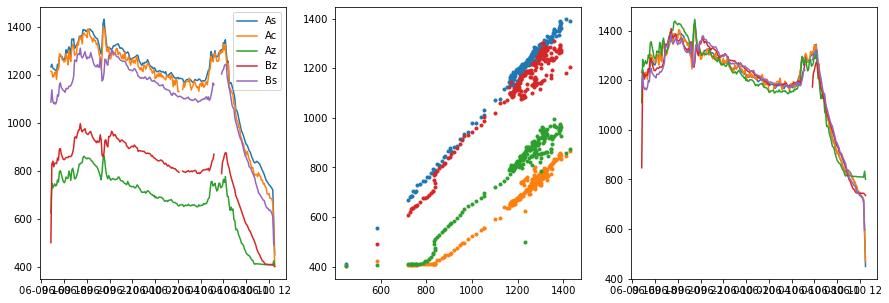

In [99]:
from matplotlib import pyplot as plt
import pandas, numpy
import datetime

def hoursback(h0, h1=0):
    t0 = (datetime.datetime.utcnow() - datetime.timedelta(hours=h0)).isoformat(" ", "seconds")
    t1 = (datetime.datetime.utcnow() - datetime.timedelta(hours=h1)).isoformat(" ", "seconds")
    return t0, t1

# read the two sensors between a period of times and find the line of regression to calibrate them
t0, t1 = '2022-06-09 14:30:03', '2022-06-10 12:30:03'
#t0, t1 = '2022-06-09 14:30:03', '2022-06-10 14:30:03'
#t0, t1 = '2022-06-10 13:20:03', '2022-06-10 14:00:03'
#t0, t1 = hoursback(24)
print("t0, t1 = '%s', '%s'" % (t0, t1))

devicesensor = {"As":('AB4634', "scd30"), 
                "Ac":('AB4634', "CDM7160"), 
                "Az":('AB4634', "MHZ19"), 
                "Bz":('05DB14', "MHZ19"),
                "Bs":('05DB14', "scd30") }
dev0 = "As"
timerange = "time>'%s' and time<'%s'" % (t0, t1)
groupby = "group by time(5m)"
dfs = [ ]
for key in devicesensor:
    device, sensor = devicesensor[key]
    query = "select mean(co2) as co2_%s from julianhouse where device='%s' and sensor='%s' and %s %s" % \
                (key, device, sensor, timerange, groupby)
    s = dclient.query(query)
    k = s["julianhouse"]
    k = k[k<3000]
    k = k.dropna()
    dfs.append(k)
co2minutes = pandas.concat(dfs, axis=1)

fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
for key in devicesensor:
    plt.plot(co2minutes["co2_%s"%key], label=key)
plt.legend()

ax = plt.subplot(1,3,2)
dat0 = co2minutes["co2_%s"%dev0]
dat1moved = [ ]
print("add the calculations below into the grafana math node")
for key in devicesensor:
    if key == dev0:
        continue
    dat1 = co2minutes["co2_%s"%key]
    plt.scatter(dat0, dat1, marker=".")
    df = pandas.DataFrame({"dat1":dat1, "dat0":dat0})
    df = df.dropna()
    model1 = numpy.polyfit(df.dat1, df.dat0, 1)
    print(key, 'mean("co2")*%f + %f' % tuple(model1))
    dat1moved.append(dat1*model1[0] + model1[1])
    
ax = plt.subplot(1,3,3)
plt.plot(dat0)
for dat1m in dat1moved:
    plt.plot(dat1m)



As
Ac
Az
Bz
Bs


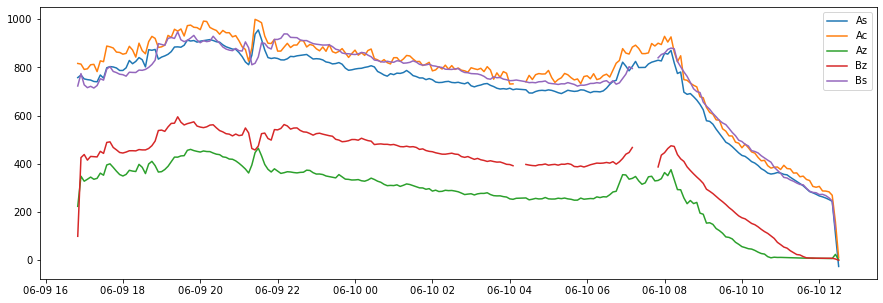

In [110]:
fig = plt.figure(figsize=(15,5))
for key in devicesensor:
    print(key)
    plt.plot(co2minutes["co2_%s"%key] - outsidemean[key], label=key)
plt.legend()


In [ ]:
ax = plt.subplot(1,3,2)
dev0 = devices[0]
dat0 = co2minutes["co2_%s"%dev0]
dat1moved = [ ]
print("add the calculations below into the grafana math node")
for dev1 in devices[1:]:
    dat1 = co2minutes["co2_%s"%dev1]
    plt.plot(dat0, dat1)
    model1 = numpy.polyfit(dat1, dat0, 1)
    print(dev1, 'mean("co2")*%f + %f' % tuple(model1))
    dat1moved.append(dat1*model1[0] + model1[1])
    
ax = plt.subplot(1,3,3)
plt.plot(dat0)
for dat1m in dat1moved:
    plt.plot(dat1m)


In [48]:
co2minutes.co2_Ca

2022-05-16 09:17:00+00:00    1335.555216
2022-05-16 09:18:00+00:00    1334.270039
2022-05-16 09:19:00+00:00    1336.898429
2022-05-16 09:20:00+00:00    1334.911519
2022-05-16 09:21:00+00:00    1331.906723
                                ...     
2022-05-16 17:13:00+00:00    1040.722796
2022-05-16 17:14:00+00:00    1040.030903
2022-05-16 17:15:00+00:00    1041.923408
2022-05-16 17:16:00+00:00    1052.348283
2022-05-16 17:17:00+00:00    1066.901803
Name: co2_Ca, Length: 481, dtype: float64

(0.004699859680933346, 1385.1318192290871)


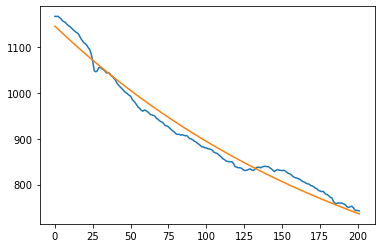

In [122]:

t0, t1 = '2022-06-10 08:40:03', '2022-06-10 12:01:03'
key = "As"
#key = "Bs"
device, sensor = devicesensor[key]

timerange = "time>'%s' and time<'%s'" % (t0, t1)
groupby = "group by time(1m)"
query = "select mean(co2) as co2 from julianhouse where device='%s' and sensor='%s' and %s %s" % (device, sensor, timerange, groupby)
s = dclient.query(query)
co2minutes = s["julianhouse"]

t0 = co2minutes.index[0] 
minute = (co2minutes.index - t0)/pandas.Timedelta(seconds=60)

X2 = outsidemean[key]

import scipy.optimize
def fun(X):
    d = numpy.exp((X[1]-minute)*X[0]) + X2 - co2minutes.co2
    #d = numpy.exp((X[1]-minute)*X[0]) + X[2] - co2minutes.co2
    return sum(d**2)
#plt.plot(minute, co2minutes)
#plt.plot(minute, numpy.exp((300-minute)*0.02) + 540)
#sol = scipy.optimize.minimize(fun, (0.02, 300.0, 540.0), method="Powell")
sol = scipy.optimize.minimize(fun, (0.02, 300.0), method="Powell")
print(tuple(sol.x))

plt.plot(minute, co2minutes.co2)
#X = (0.0024794527285277386, 2480.5077884406514, 872.3654447662688)
X = sol.x
#plt.plot(minute, numpy.exp((X[1]-minute)*X[0]) + X[2])
plt.plot(minute, numpy.exp((X[1]-minute)*X[0]) + X2)

# CO2 = e^(2480-time_minutes) + 872  -- ie in 41 hours it will have decayed to value of 873
# Rate of decay will be 0.0025 points per minute, requiring 0.0025*Vol of air per minute

# rate of decay at t=0 is e^(-2480*0.024)*0.024 / e^(-2480*0.024) = 0.024

In [121]:
key, outsidemean[key]
# Bs: (0.0049676076443888545, 1329.9638679359018)
# As: (0.004699859680933346, 1385.1318192290871)

('Bs', 362.70638105316897)

In [83]:
# Room size is 5.4 x 3.4 x 2.8 = 51.4 m^3
# 0.0025 * 51.4 * 1000 = 127.4 l/minute"
# ACPH = 127.4*60/(51.4*1000)
127.4*60/(51.4*1000)
0.0025*60

0.15

In [85]:
13*240

3120

In [223]:
# Rate of exchange is 0.015*190*1000 = 2850 l/m
# It had been around a concentration of 0.0012
# This means the production of CO2/minute was 2850*(0.0012-0.000540)=1.88 l/m CO2
# or a production of around 0.313 l/m per person (there were 6 people)


0.31349999999999995

In [165]:
# readings approx 0.000770 when one person asleep in house, then 0.000400 when doors open
# CO2 production of a sleeping person is 0.25 l/m
# if E is the exchange volume per minute, this differential is stable if E*(0.000770 - 0.000400) = 0.25
# E = 0.25/0.00037 = 675 l/m
# If the volume of the house is 120 m3 then it's an air exchange of 120/0.675 or once every 3hrs

# My calculation is: Air exchange = Human production of CO2/(inside_CO2_concentration - outside_CO2_concentration)
#                                 = 0.25/(0.000770 - 0.000400) = 675 litres/minute
# Air exchanges per hour = Air exchange/House volume = 675*60/120000 = 0.33 exchanges per hour


0.3375

In [215]:
import scipy.optimize
def fun(X):
    d = numpy.exp((X[1]-minute)*X[0]) + X[2] - co2minutes.co2_7AEDB8
    return sum(d**2)
#plt.plot(minute, co2minutes)
#plt.plot(minute, numpy.exp((300-minute)*0.02) + 540)
sol = scipy.optimize.minimize(fun, (0.02, 300.0, 540.0), method="Powell")
print(tuple(sol.x))

(0.015661117030946754, 388.20725005952175, 540.2508613438699)


[0.0156565828, 436.942807, 540.222792]

(0.015661117030946754, 388.20725005952175, 540.2508613438699)


380.65862957756644

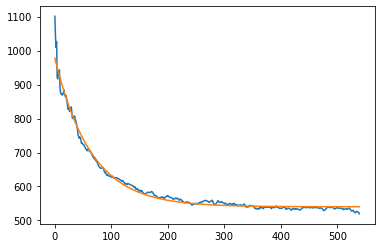

In [216]:
import scipy.optimize
plt.plot(minute, co2minutes.co2_7AEDB8)
X = (0.015661117030946754, 388.20725005952175, 540.2508613438699)
plt.plot(minute, numpy.exp((X[1]-minute)*X[0]) + X[2])


In [256]:
# this turns out to be the Savitzky-Golay filter
sec1 = pandas.Timedelta(seconds=1)
def intercurvefitdifferentiate(seriestimeindex, rx, ws, deg=3):
    rx0 = pandas.Series(0, seriestimeindex)
    rx1 = pandas.Series(0, seriestimeindex)
    rx2 = pandas.Series(0, seriestimeindex)
    wt = ws*sec1
    wt2 = ws*2*sec1
    wt4 = ws*4*sec1
    for n in range(len(seriestimeindex)):
        t = seriestimeindex[n]
        lx = rx[t-wt:t+wt]
        if len(lx) <= 3:
            lx = rx[t-wt2:t+wt2]
            if len(lx) <= 3:
                lx = rx[t-wt4:t+wt4]
                if len(lx) <= 3:
                    #print(t)
                    continue
        ts = (lx.index - t)/sec1
        weights = 1/((abs(ts)/ws)**2+1)
        pm = numpy.polyfit(ts, lx, deg=deg, w=weights)
        rx0.iloc[n] = numpy.polyval(pm, 0)
        pm1 = numpy.polyder(pm)
        rx1.iloc[n] = numpy.polyval(pm1, 0)
        pm2 = numpy.polyder(pm, 2)
        rx2.iloc[n] = numpy.polyval(pm2, 0)
    return rx0, rx1, rx2


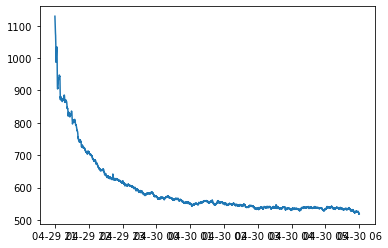

In [258]:
t0, t1 = '2022-04-29 21:00:00', '2022-04-30 06:00:00'
device = '7AEDB8'
timerange = "time>'%s' and time<'%s'" % (t0, t1)
query = "select co2 as co2_%s from julianhouse where device='%s' and %s" % (device, device, timerange)
s = dclient.query(query)
rx = s["julianhouse"]["co2_7AEDB8"]

plt.plot(rx)

In [287]:
seriestimeindex = pandas.date_range(rx.index[0], rx.index[-1], freq="180s")
rx0, rx1, rx2 = intercurvefitdifferentiate(seriestimeindex, rx, 6000, deg=3)

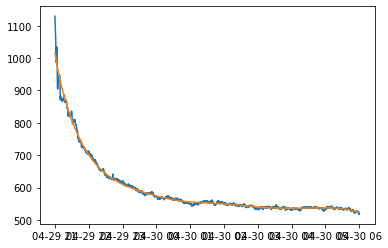

In [288]:
plt.plot(rx)
plt.plot(rx0)


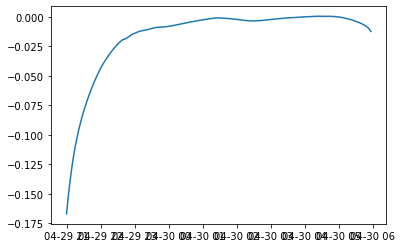

In [291]:
plt.plot(rx1)

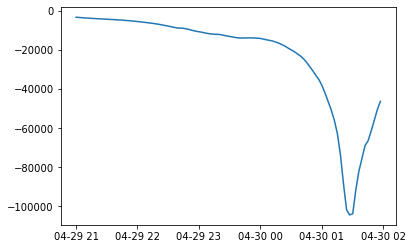

In [298]:
y = (rx0-460)/rx1
plt.plot(y[:100])

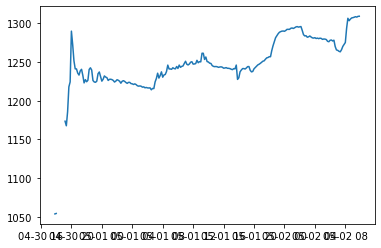

In [339]:
t0 = (datetime.datetime.utcnow() - datetime.timedelta(hours=40))
t0u = t0.isoformat(sep=" ", timespec="seconds")
s = dclient.query("select pow(10, (8.1332 - 1762.39/(mean(temp)+235.66)))*133.322387415*mean(humid)/100 as wv from julianhouse where device='7AEDB8' and time>'%s' group by time(10m);" % t0u)
#wv = 10**(8.1332 - 1762.39/(df["temp"] + 235.66))*133.322387415*df["humid"]/100
plt.plot(s["julianhouse"])


In [322]:
t0 = (datetime.datetime.utcnow() - datetime.timedelta(seconds=1000))
t0u = t0.isoformat(sep=" ", timespec="seconds")
print(t0, t0u)
#s = dclient.query("select co2, humid, temp from julianhouse where device='7AEDB8' and time>'%s';" % t0u)
s = dclient.query("select mean(co2), mean(humid), mean(temp) from julianhouse where device='7AEDB8' and time>'%s' group by time(10m);" % t0u)

#s = dclient.query("select co2 from julianhouse where time>'2022-04-30 16:00:05' limit 10;")
df = s["julianhouse"]
svp = 10**(8.1332 - 1762.39/(df["temp"] + 235.66))*133.322387415
watervapour = svp*df["humid"]/100

wv = 10**(8.1332 - 1762.39/(df["temp"] + 235.66))*133.322387415*df["humid"]/100

plt.plot(wv)
def SaturationVapourPressure(tempseries):
    A, B, C = 8.1332, 1762.39, 235.66
    return 10**(A - B/(tempseries + C))*133.322387415
    
def DewpointTemperature(tempseries, humidseries):
    A, B, C = 8.1332, 1762.39, 235.66
    svp = 10**(A - B/(tempseries + C))*133.322387415
    pvp = svp*humidseries/100
    return -C - B/(numpy.log10(pvp/133.322387415) - A)

# http://en.wikipedia.org/wiki/Density_of_air
def AirDensity(tempseries, humidityseries, pressureseries):
    saturationvapourpressure = SaturationVapourPressure(tempseries)
    PPwatervapour = SaturationVapourPressure(tempseries)*humidityseries/100
    PPdryair = pressureseries - PPwatervapour
    Rdryair = 287.058
    Rwatervapour = 461.495
    tempK = tempseries + 273.15
    return PPdryair/(Rdryair*tempK) + PPwatervapour/(Rwatervapour*tempK)
df


2022-05-02 09:36:22.399547 2022-05-02 09:36:22


KeyError: 'temp'